In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import networkx as nx
import os
import pandas as pd
import random
import scipy.linalg
import seaborn as sns
import time
from tqdm.notebook import tqdm
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
%matplotlib inline

In [220]:
def adam(g, m, v, t, b1=0.9, b2=0.999, stepsize=0.01, eps=1e-8, clip = None):
    m = (1 - b1) * g      + b1 * m    # First  moment estimate.
    v = (1 - b2) * (g**2) + b2 * v    # Second moment estimate.
    mhat = m / (1 - b1**(t + 1))    # Bias correction.
    vhat = v / (1 - b2**(t + 1))
    delta = (lr * mhat) / (np.sqrt(vhat) + eps)
    norm = np.sum(np.square(delta))
    if clip is not None and norm > clip:
        delta /= norm
    return delta, m, v, t+1

def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""
    def omega_approx(beta):
        """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
        return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

    def lambda_star(beta):
        """Return lambda star for given beta. Equation (11) from Gavish 2014."""
        return np.sqrt(2 * (beta + 1) + (8 * beta) / 
                   (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma

(3, 20000)
(9, 10000)
47


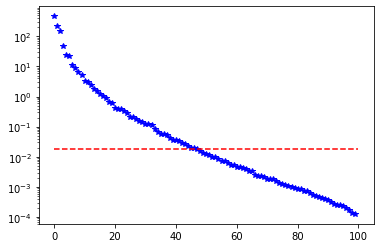

In [420]:

# system_name =    'Rossler'
# system_name =    'Rabinovich Fabrikant'
system_name =    'Lorenz'
# system_name =    'Chua'
# U1 = U_pendulum[2:]
U1 = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T[:3]
U= U1
U = U + np.random.randn(*U.shape)*1e-3
U = np.atleast_2d(U)
print(U.shape)

num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 1000
test_start = num_prepare + num_train + num_val
num_test = 5000


seed = 42
dt = 0.1
eps = 1e-6
K = 1
Ps= [0.05,0.5,0.95]
horizon = 1
input_scaling = 1

Nu = U.shape[0]
T = U.shape[1]
Nx = 100
P = np.diag([ p for p in Ps for _ in range(Nu)])
Ny = len(Ps)*Nu

x = np.random.random((Nx,1))
W = np.random.random((Nx,Nx))
# g = nx.erdos_renyi_graph(Nx, 0.1, seed, True)
# W = np.asarray(nx.adjacency_matrix(g).todense())
largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])
W = W/rhoW*K
Win = (np.random.random((Nx,Nu+1))*2-1)*input_scaling
Wout = np.random.random((Ny,Nx+1))*2-1

f = np.tanh
df = lambda x:1-np.square(np.tanh(x))

X = np.zeros((Nx,T))

for t in range(T):
    u = np.vstack([1,U[:,t:t+1]])
    fs = f(W @ x + Win @ u)
    x = (1-dt)* x + dt * fs
    h = np.vstack([1,x])
    y = Wout @ h
    X[:,t:t+1] = x

# offline train
U_train = U[:,train_start : train_start + num_train]
X_train = X[:,train_start : train_start + num_train]
Y_train = np.vstack([U[:,train_start + horizon : train_start + num_train + horizon] for _ in range(len(Ps))])
print(Y_train.shape)

Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
tau = svht(X_train, sv=Diag)
Nv = np.sum(Diag>tau)
print(Nv)
plt.figure()
plt.plot(Diag, 'b*', label='sigular values')
plt.plot([0,len(Diag)],[tau,tau], 'r--', label=r'$\sigma$ unknown')
plt.yscale('log')
plt.show()
MlT, Diag, Mr = Ml.T[:Nv], Diag[:Nv], Mr[:Nv]

# H = np.vstack((np.ones((1,X_train.shape[1])), X_train))
# Wout = np.random.random((Ny,Nx+1))*2-1
H = np.vstack((np.ones((1,X_train.shape[1])),MlT @ X_train))
Wout = np.random.random((Ny,Nv+1))*2-1
# Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + eps*np.eye(H.shape[0]))


In [427]:
# Wout = np.random.random((Ny,Nv+1))*2-1
# gradient descent
m, v, ite = 0,0,0
Loss_hitory = []
for epoch in range(10000):
    Y_pred = Wout @ H
    L = P @ (Y_train - Y_pred) + (Y_pred > Y_train).astype(np.float) * (Y_pred - Y_train)
    Loss = np.sum(L)
    Loss_hitory.append(Loss)
    dY = -((Y_pred > Y_train).astype(float)- np.sum(P,axis=1,keepdims=True))
    dWout = dY @ H.T
    delta, m, v, ite = adam(dWout, m, v, ite, b1=0.9, b2=0.999,stepsize=0.01, clip=1) #np.sqrt(np.sum(np.square(Wout)))
#     Wout += delta
    Wout += 0.00000001*dWout
    if epoch % 100 == 0:
        print('epoch: {} loss: {} dY: {}'.format(epoch,Loss,np.sum(dY)))

print('pre_output shape:', H.shape)
print('W_out shape:', Wout.shape)  
print('train err: ',Loss)

epoch: 0 loss: 529770.6673387988 dY: -367.00000000000097
epoch: 100 loss: 529767.6232386064 dY: -365.00000000000097
epoch: 200 loss: 529764.5844654149 dY: -366.00000000000097
epoch: 300 loss: 529761.5499808452 dY: -361.00000000000097
epoch: 400 loss: 529758.5207015063 dY: -365.00000000000097
epoch: 500 loss: 529755.4970622379 dY: -363.00000000000097
epoch: 600 loss: 529752.4793226726 dY: -362.00000000000097
epoch: 700 loss: 529749.469475072 dY: -364.00000000000097
epoch: 800 loss: 529746.468154 dY: -363.00000000000097
epoch: 900 loss: 529743.4713445702 dY: -363.00000000000097
epoch: 1000 loss: 529740.4794150874 dY: -371.00000000000097
epoch: 1100 loss: 529737.4911497027 dY: -366.00000000000097
epoch: 1200 loss: 529734.5096589052 dY: -362.00000000000097
epoch: 1300 loss: 529731.5370778232 dY: -359.00000000000097
epoch: 1400 loss: 529728.5756414894 dY: -360.00000000000097
epoch: 1500 loss: 529725.6231104386 dY: -358.00000000000097
epoch: 1600 loss: 529722.6755292842 dY: -352.000000000000

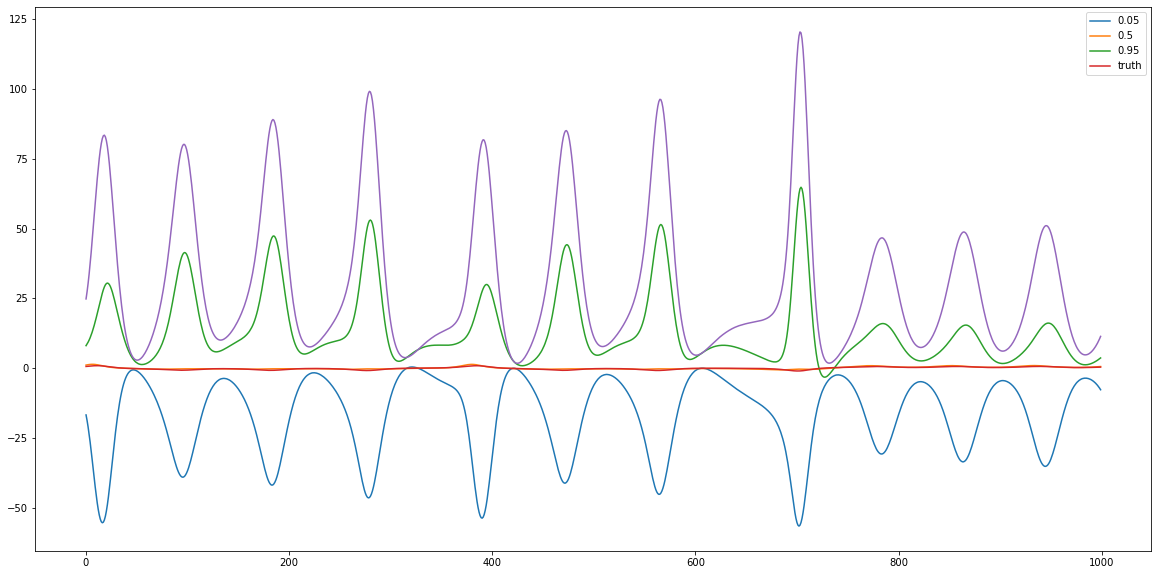

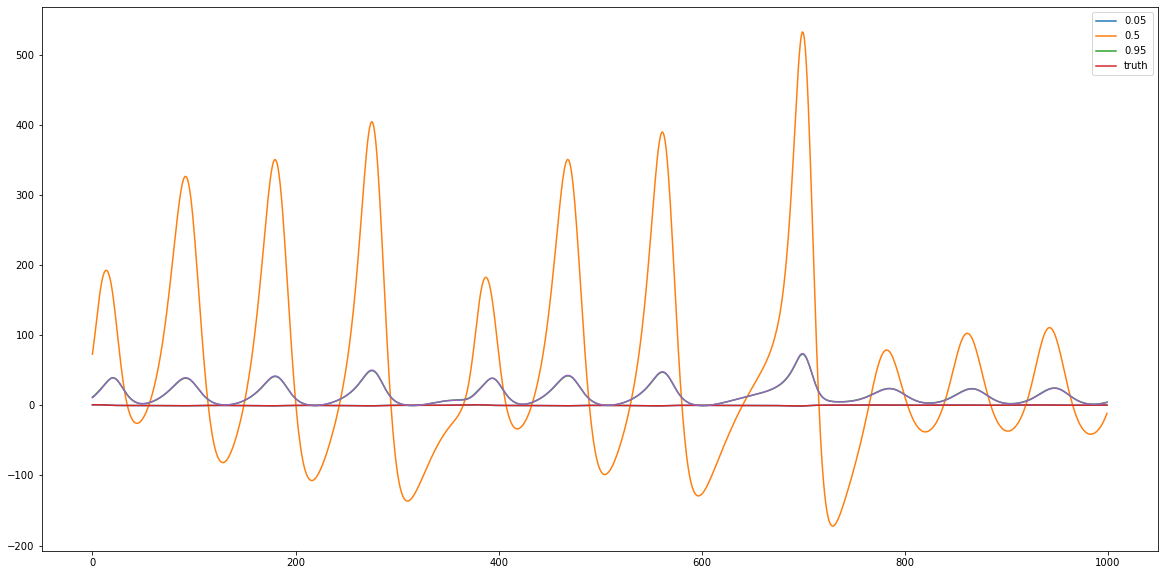

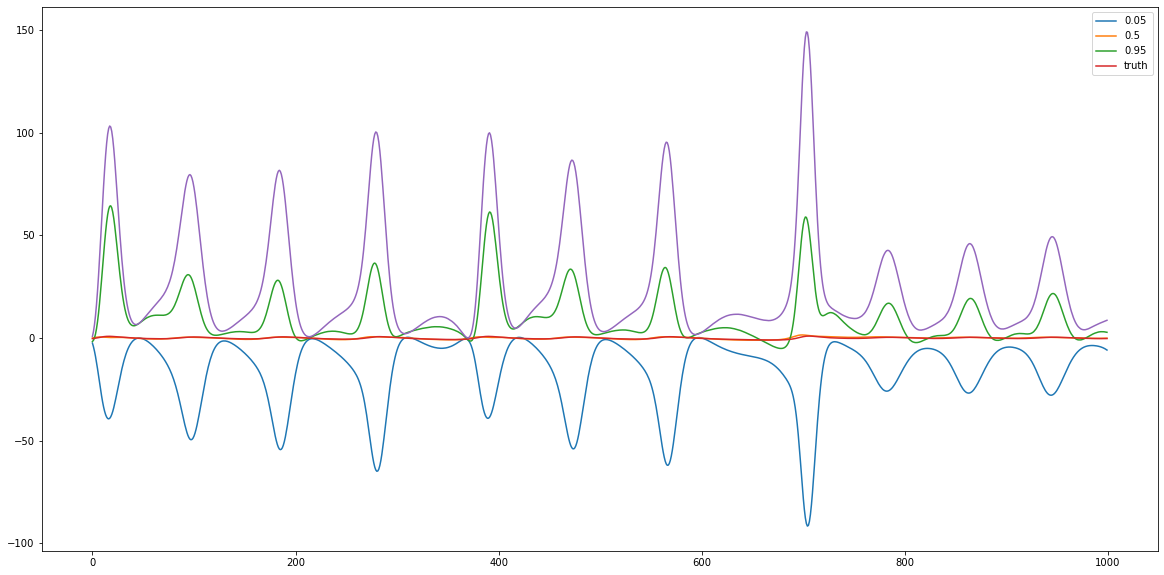

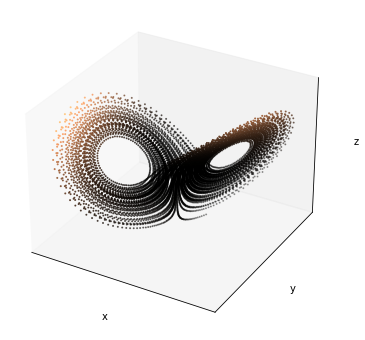

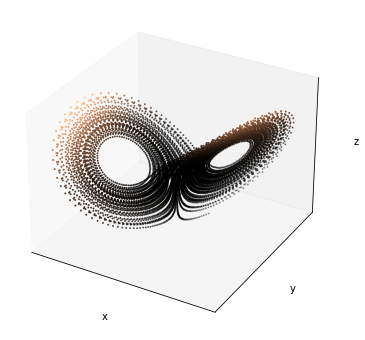

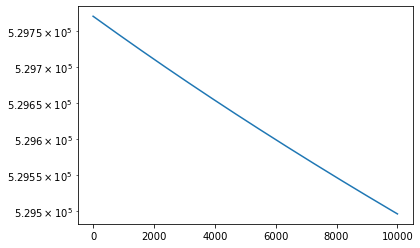

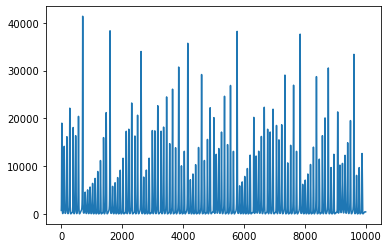

In [428]:
# 1d
num_show = 1000
C = np.zeros((Nu,num_train))
for i in range(Nu):
    plt.figure(figsize=(20,10))
    indice = [i,Nu+i,2*Nu+i]
    plt.plot(Y_pred[indice,:num_show].T)
    plt.plot(Y_train[i,:num_show].T)
    plt.plot(Y_pred[2*Nu+i,:num_show].T - Y_pred[i,:num_show].T)
    C[i] = Y_pred[2*Nu+i] - Y_pred[i]
    plt.legend(labels=['0.05','0.5','0.95','truth'])
    plt.show()

    
c = np.sum(np.square(C),axis=0)
# c = np.max(C,axis=0)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=90, azim=90)
# ax.plot(*U_train[:Nu], alpha=0.5)
ax.scatter(*U_train[:Nu], s=1,c=c, cmap='copper')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# plt.grid(True)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=90, azim=90)
ax.scatter(*Y_train[:Nu], s=1,c=c, cmap='copper')
# ax.plot(*Y_train[:Nu], alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.grid()
plt.show()

plt.figure()
plt.plot(Loss_hitory)
plt.yscale('log')
plt.show()

plt.plot(c)

95%:  0.12943644126129608


TypeError: scatter() missing 1 required positional argument: 'y'

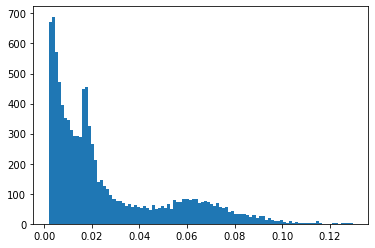

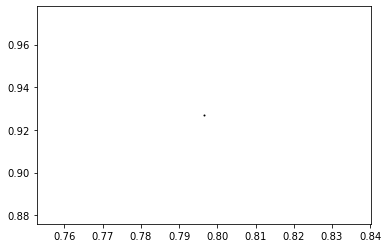

<Figure size 432x288 with 0 Axes>

In [407]:
plt.figure()
_ = plt.hist(c,bins=100)

q95 = np.quantile(c, 0.9999)
print('95%: ',q95)
mask = c>q95
plt.figure()
plt.scatter(*U_train[:2,mask], s=1,c=c[mask], cmap='copper')

plt.figure()
plt.scatter(*U_train[2:4,mask], s=1,c=c[mask], cmap='copper')

for i in np.where(mask)[0].tolist():
    state = np.diag(pmax - pmin) @(U_train[:,i] + 1)/2 +pmin
    show_state(state)
# np.where(c>q95)[0]

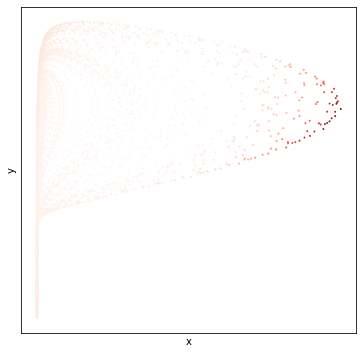

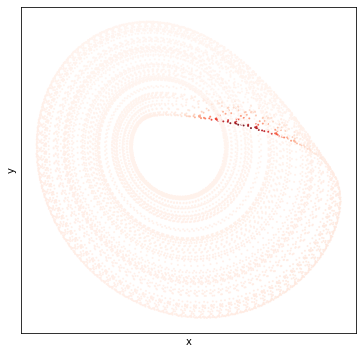

In [372]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# ax.view_init(elev=90, azim=90)
ax.scatter(*Y_train[2:4], s=1,c=c, cmap='Reds',alpha=0.8)
# ax.plot(*Y_train[:Nu], alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks([])
ax.set_yticks([])
plt.grid()
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# ax.view_init(elev=90, azim=90)
ax.scatter(*Y_train[:2], s=1,c=c, cmap='Reds',alpha=0.8)
# ax.plot(*Y_train[:Nu], alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks([])
ax.set_yticks([])
plt.grid()
plt.show()

# test

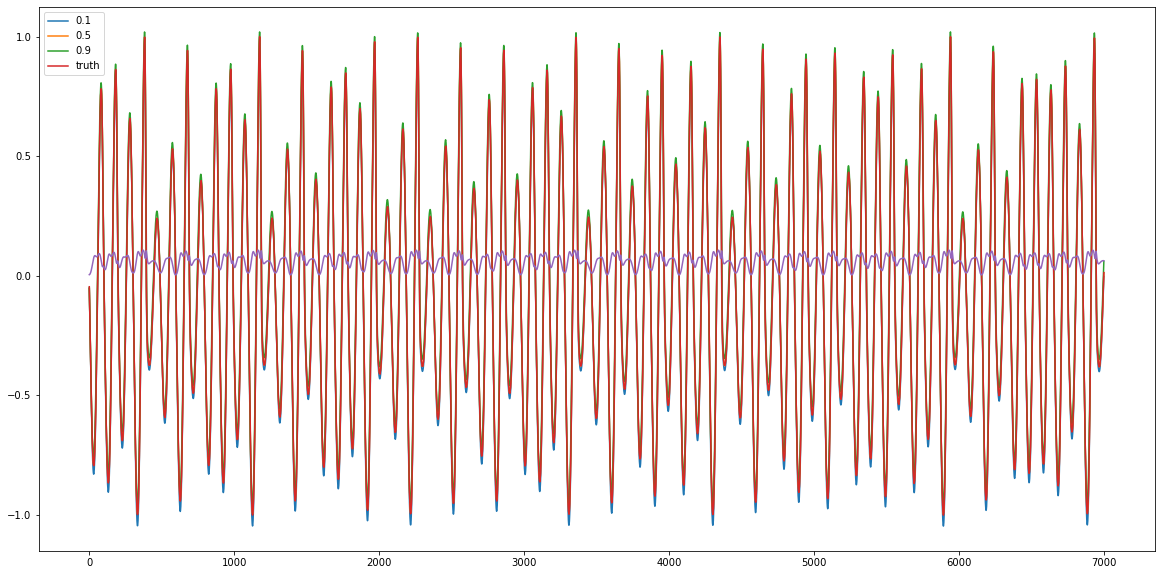

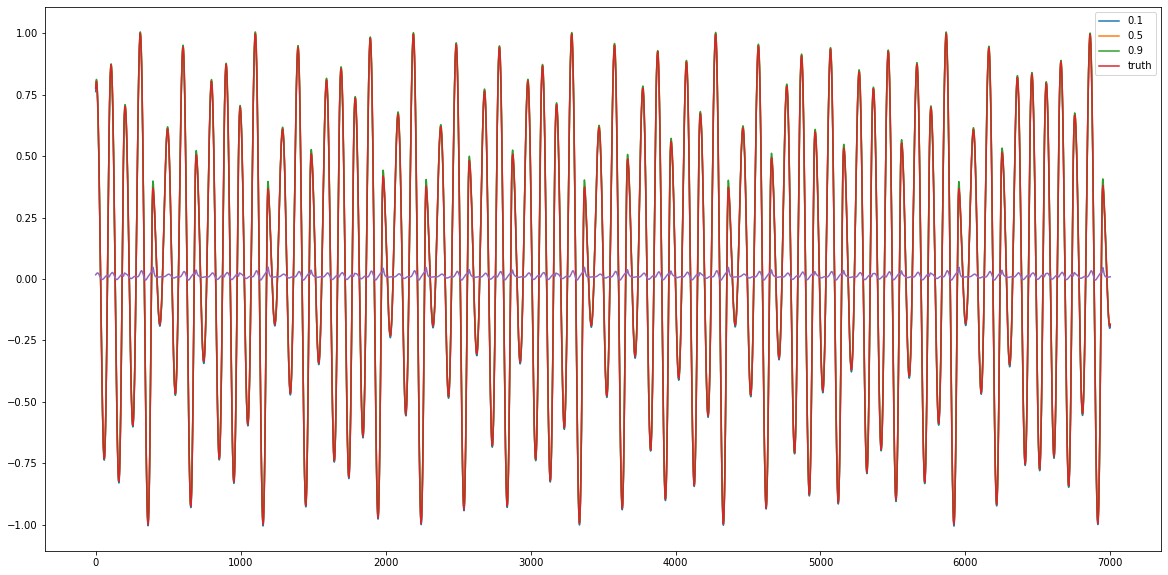

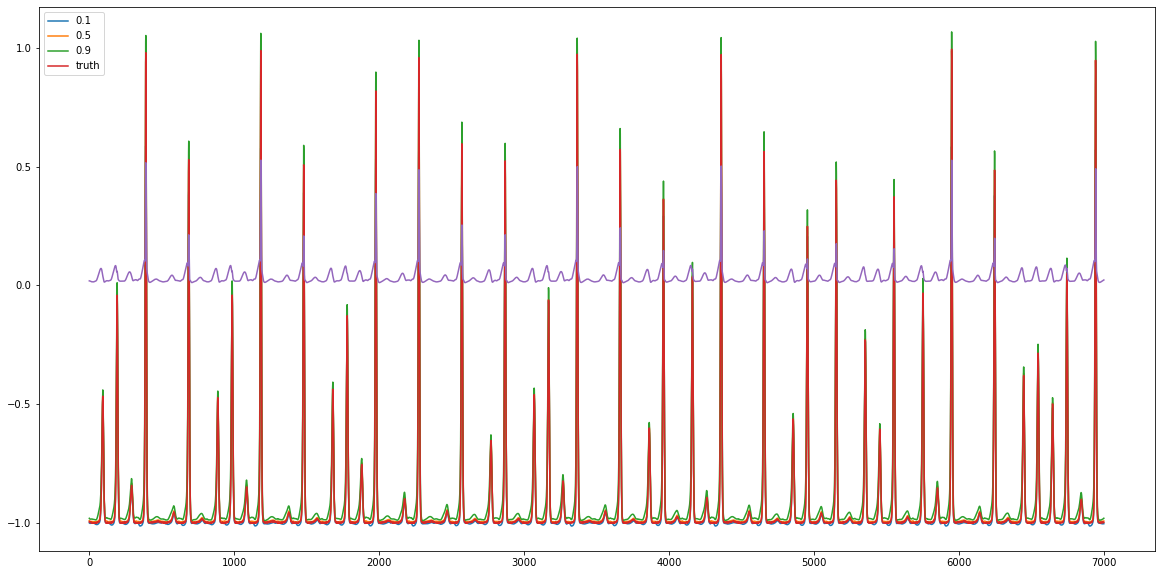

[0.00463082 0.00485817 0.00528797 ... 0.06316076 0.06304859 0.06285474]


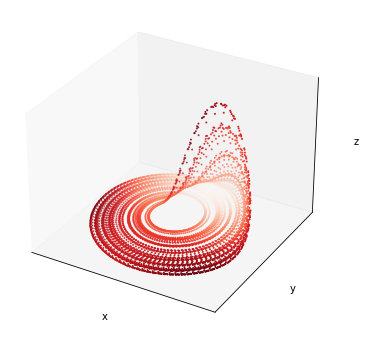

[0.01710452 0.01791532 0.01873337 ... 0.00859263 0.00869885 0.00879515]


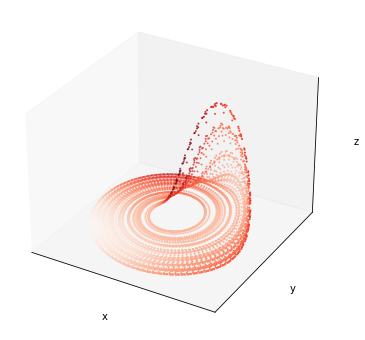

[0.01925705 0.01915126 0.01903193 ... 0.02205553 0.02247866 0.02297123]


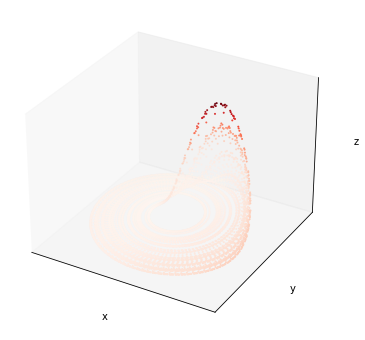

In [373]:
num_test = 7000

U_test = U[:,test_start : test_start + num_test]
X_test = X[:,test_start : test_start + num_test]
Y_test = U[:,test_start+horizon : test_start + num_test +horizon]

H = np.vstack((np.ones((1,num_test)),MlT@ X_test))
Y_pred = Wout @ H

C = np.zeros((Nu,num_test))
for i in range(Nu):
    plt.figure(figsize=(20,10))
    indice = [i,Nu+i,2*Nu+i]
    plt.plot(Y_pred[indice].T)
    plt.plot(Y_test[i].T)
    plt.plot(Y_pred[2*Nu+i].T - Y_pred[i].T)
    C[i] = Y_pred[2*Nu+i] - Y_pred[i]
    plt.legend(labels=['0.1','0.5','0.9','truth'])
    plt.show()

for i in range(Nu):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
#     ax.view_init(elev=90, azim=90)
#     c = np.sum(C,axis=0)
    c = C[i]
    print(c)
    ax.scatter(*Y_test, s=1,c=c, cmap='Reds')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.grid(True)
    plt.show()

In [266]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg
t_stop = 400  # how many seconds to simulate


def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (M1+M2) * L1 - M2 * L1 * cos(delta) * cos(delta)
    dydx[1] = ((M2 * L1 * state[1] * state[1] * sin(delta) * cos(delta)
                + M2 * G * sin(state[2]) * cos(delta)
                + M2 * L2 * state[3] * state[3] * sin(delta)
                - (M1+M2) * G * sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (L2/L1) * den1
    dydx[3] = ((- M2 * L2 * state[3] * state[3] * sin(delta) * cos(delta)
                + (M1+M2) * G * sin(state[0]) * cos(delta)
                - (M1+M2) * L1 * state[1] * state[1] * sin(delta)
                - (M1+M2) * G * sin(state[2]))
               / den2)

    return dydx

# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.02
t = np.arange(0, t_stop, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 180.0
w1 = 0.0
th2 = 180.1
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])
x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

U_pendulum = np.vstack([x1,y1,x2,y2])
pmax, pmin = np.max(U_pendulum,axis=1),np.min(U_pendulum,axis=1)
U_pendulum = np.diag(1./(pmax - pmin)) @ (U_pendulum - pmin.reshape((-1,1))) *2 -1

print(U_pendulum.shape)

(4, 20000)


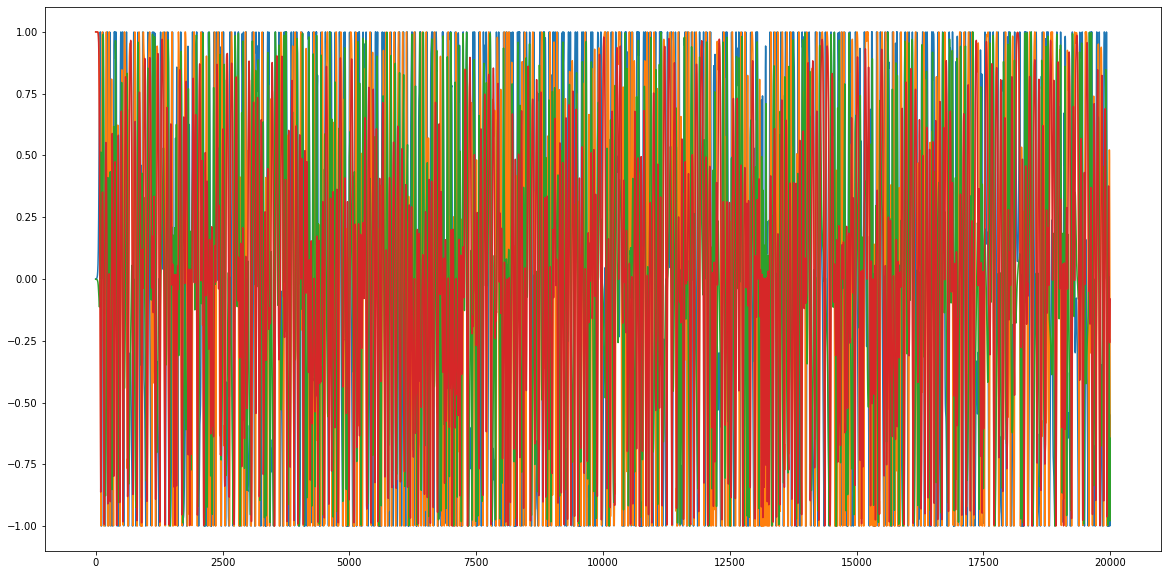

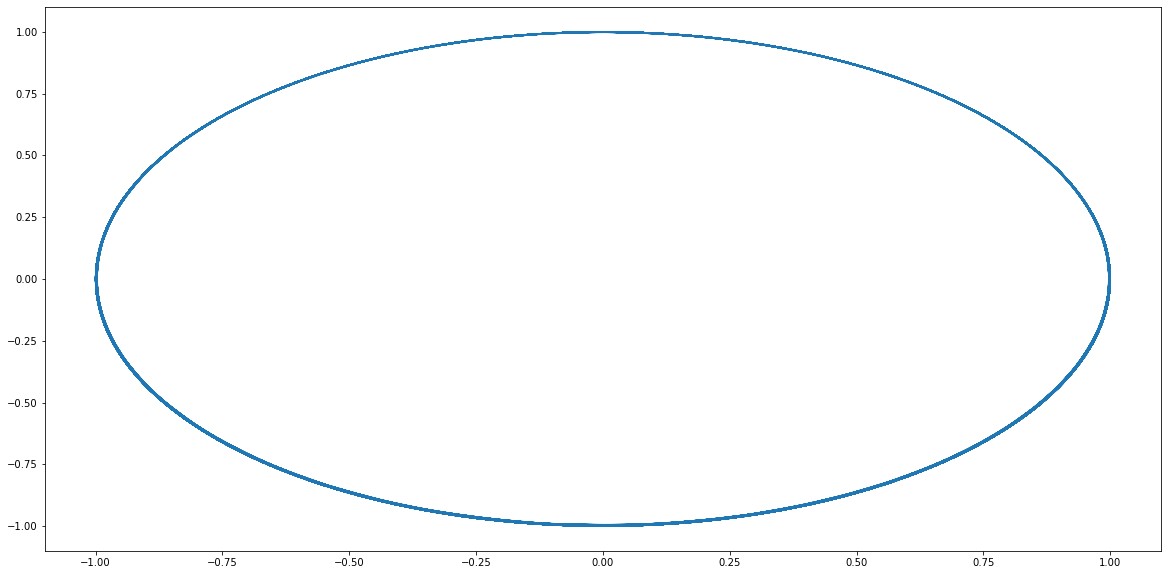

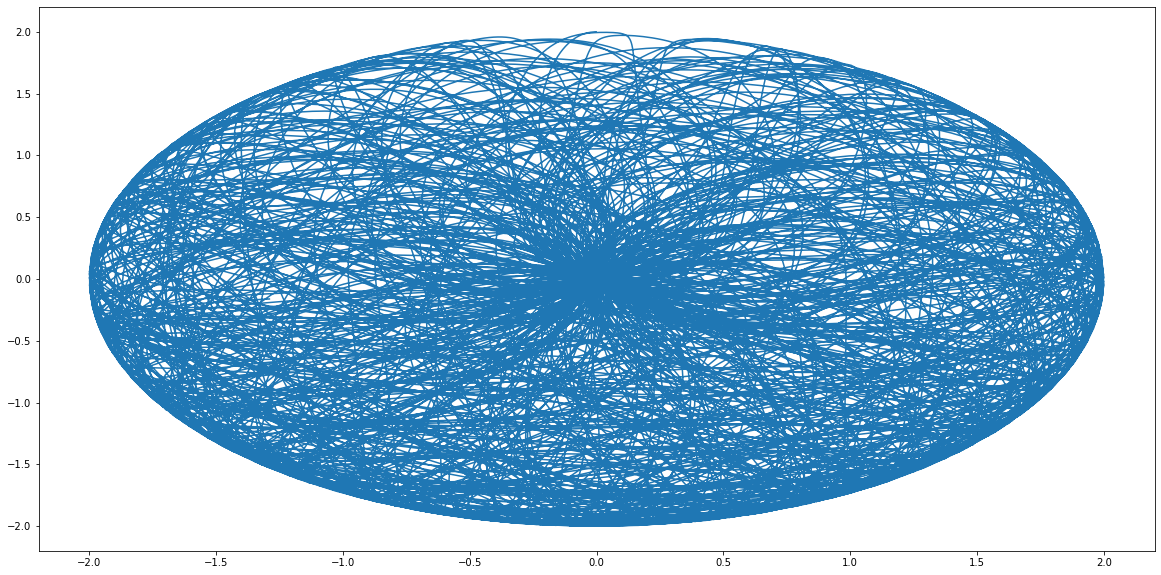

In [259]:
plt.figure(figsize=(20,10))
plt.plot(U_pendulum.T)
plt.show()

plt.figure(figsize=(20,10))
plt.plot(x1,y1)
plt.show()

plt.figure(figsize=(20,10))
plt.plot(x2,y2)
plt.show()

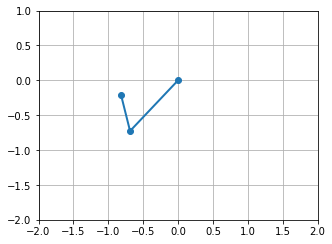

In [274]:
def show_state(state):
    x1,y1,x2,y2 = state[0],state[1],state[2],state[3]
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 1))
    ax.set_aspect('equal')
    ax.grid()

    line, = ax.plot([], [], 'o-', lw=2)
    thisx = [0, x1, x2]
    thisy = [0, y1, y2]
    line.set_data(thisx, thisy)

    plt.show()
    
show_state(U_train[:,0])

# lyapunov 

  0%|          | 0/10000 [00:00<?, ?it/s]

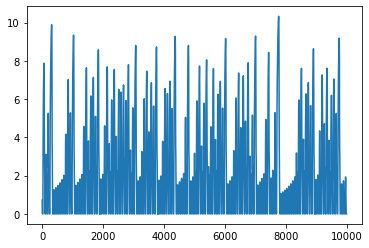

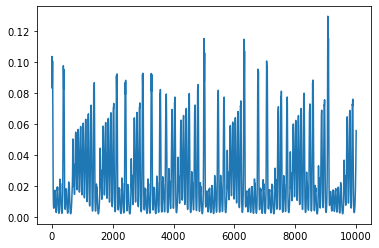

In [409]:

U_raw = np.loadtxt('dataset/matlab_gendata/'+system_name+'_raw.csv', delimiter=',').T[:3]

def LorenzLyp(X):
    x,y,z = X[0],X[1],X[2]
    a = 10
    b = 28
    c = 8/3

    L = np.array([
        [-a, a, 0],
        [b-z, -1, -x],
        [y, x, -c]
    ])
    return max(np.real(np.linalg.eig(L)[0]))

def RosslerLyp(X):
    x,y,z = X[0],X[1],X[2]
    a = 0.20
    b = 0.20
    c = 5.7

    L = np.array([
        [0,-1, -1],
        [1, a, 0],
        [z, 0, x-c]
    ])
    return max(np.real(np.linalg.eig(L)[0]))

Ls = []
for i in tqdm(range(train_start,train_start+num_train)):
    l = LorenzLyp(U_raw[:,i])
    Ls.append(max(0,l))
plt.plot(Ls)
plt.figure()
plt.plot(c)

[]

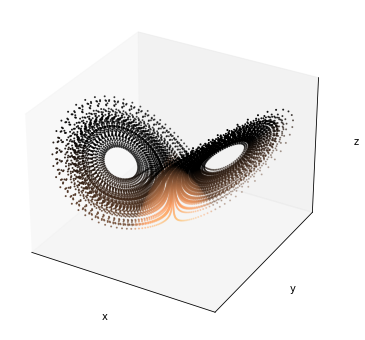

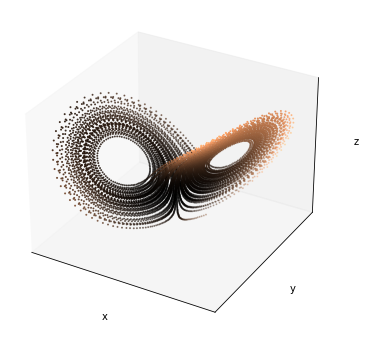

In [408]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*U_raw[:,train_start:train_start+num_train], s=1,c=Ls, cmap='copper')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*U_train, s=1,c=np.log(1+c), cmap='copper')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])